In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from get_from_web import get_from_web

f2save = 'owid-covid-data.xlsx'
download_url = 'https://covid.ourworldindata.org/data/' + f2save

In [ ]:
#GET file from web
if True:
    #def get_from_web(download_url, headers=None, num_recurr=1, f2save=None, n_attempts=2):
    ret_code, _ = get_from_web(download_url, f2save=f2save)
    print(ret_code)

#GET file from hdd
df = pd.read_excel(f2save)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', drop=False, inplace=True)

#add year, week numbers
df['year'] = df.index.isocalendar().year
df['week'] = df.index.isocalendar().week
df.tail(5)

In [ ]:
def create_weekly(df_in):
    """creates weekly data per county"""
    df_weekly = []
    countries = df_in.location.unique()
    for country in countries:
        mask = df_in.location == country
        if ~mask.any():
            #empty fileset
            continue
        df_ctry = df_in[mask].copy()

        #fillna people_fully_vaccinated_per_hundred
        col = 'people_fully_vaccinated_per_hundred'
        df_ctry[col].fillna(method='ffill', inplace=True)
        #get last date for excess_mortality
        mask_isna = df_ctry.excess_mortality.isna()
        if mask_isna.all():
            #empty fileset
            continue
        last_excess_mortality_dt = df_ctry.index[~mask_isna][-1]
        mask_em = (df_ctry.index <= last_excess_mortality_dt) & (df_ctry.year == 2021) #only 2021
        #print('last date for excess_mortality for %s is %s' %(country, last_excess_mortality_dt.date()))
        #cols = ['year', 'week', 'excess_mortality', 'new_deaths', 'new_deaths_per_million', 'people_fully_vaccinated_per_hundred', 'new_cases_per_million']
        #checkpoint
        #df_ctry[cols][mask_em].head(20)

        #create new_deaths weekly based on excess_mortality data
        tmp1 = df_ctry[mask_em].groupby('week')[['new_deaths', 'new_deaths_per_million', 'new_cases_per_million']].sum()
        tmp1.columns = [col+'_weekly' for col in tmp1.columns]
        tmp2 = df_ctry[mask_em].groupby('week')[['excess_mortality', 'people_fully_vaccinated_per_hundred']].max()
        tmp = pd.concat([tmp1, tmp2], axis=1)
        tmp['gdp_per_capita'] = df_ctry.gdp_per_capita[0]
        tmp['location'] = country
        tmp['continent'] = df_ctry.continent[0]
        if df_ctry.continent[0] in ['Europe', 'North America']:
            tmp['hemisphere'] = 'Northern'
        elif df_ctry.continent[0] in ['Africa', 'South America', 'Oceania']:
            tmp['hemisphere'] = 'Southern'

        #merge
        if len(df_weekly)==0:
            df_weekly = tmp.copy()
        else:
            df_weekly = pd.concat([df_weekly, tmp], axis=0)         

    df_weekly['weeknum'] = df_weekly.index
    
    return df_weekly

def calc_corr(df_in, colx, colys):
    """calc correlation between colx and each one from colys
    colx - kolumna x; podstawa do korelacji
    colys - kolumny y; ktore korelujemy z colx"""
    df_cor = []

    #minimalny prog liczby rekordow (krajow) aby policzyc wsp korelacji
    min_corr_threshold = 10

    for coly in colys:
        corr_arr = []
        skipped_rows = []
        corr_points = [] #num of of countries used to build correlation coefficient for each week
        for wk in df_in.index.unique():
            #jesli za malo danych, nie liczymy koreacji
            mask = (df_in.index==wk) & ~df_in[coly].isna()
            corr_points.append(np.sum(mask))
            if np.sum(mask) < min_corr_threshold:
                #print('too little data for %s week:%s .skipping' %(coly, wk))
                skipped_rows.append(wk)
                continue
            corr = df_in[[colx, coly]][mask].corr().loc[colx,coly]
            corr_arr.append({'week':wk, 'corr.'+coly:corr})
            #print('{} {}'.format(wk, corr))
        
        if len(corr_arr)==0:
            print('no valid data for %s' %(coly))
            continue
        if len(skipped_rows)>0:
            print('%s avg_corr_points:%.1f skipped_rows:%s' %(coly, np.average(corr_points), str(skipped_rows)))
            
        tmp = pd.DataFrame(corr_arr).set_index('week')
        if len(df_cor)==0:
            df_cor = tmp.copy()
        else:
            df_cor = pd.concat([df_cor, tmp], axis=1)    
    
    return df_cor

In [ ]:
#create weekly data
df_weekly = create_weekly(df)

In [ ]:
#plot correlation per continent
colx='people_fully_vaccinated_per_hundred'
colys=['excess_mortality', 'new_deaths_per_million_weekly', 'new_cases_per_million_weekly']
continents = ['Asia', 'Europe', 'Africa', 'North America', 'South America', 'Oceania']
#continents = ['Europe']
for con in continents:
    print('{}'.format(con))
    df_cor = calc_corr(df_weekly[df_weekly.continent==con], colx, colys)
    #plot
    if len(df_cor)==0:
        print('nothing to plot')
        continue
    fig = df_cor.plot(title=con+':corr.'+colx)
    fig.axhline(0, color='grey', linewidth=0.5)  
    

In [ ]:
#plot correlation per hemisphere
colx='people_fully_vaccinated_per_hundred'
colys=['excess_mortality', 'new_deaths_per_million_weekly', 'new_cases_per_million_weekly', 'gdp_per_capita']
hemispheres = ['Northern']#, 'Southern']
for con in hemispheres:
    print('{}'.format(con))
    df_cor = calc_corr(df_weekly[df_weekly.hemisphere==con], colx, colys)
    #plot
    if len(df_cor)==0:
        print('nothing to plot')
        continue
    fig = df_cor.plot(title=con+':corr.'+colx)
    fig.axhline(0, color='grey', linewidth=0.5)
    fig.legend(bbox_to_anchor=(1.0, 1.0))   

In [ ]:
#plot correlation per hemisphere
colx='people_fully_vaccinated_per_hundred'
colys=['excess_mortality', 'new_deaths_per_million_weekly', 'new_cases_per_million_weekly', 'gdp_per_capita']
hemispheres = ['Northern']#, 'Southern']
for con in hemispheres:
    print('{}'.format(con))
    df_cor = calc_corr(df_weekly[df_weekly.hemisphere==con], colx, colys)
    #plot
    if len(df_cor)==0:
        print('nothing to plot')
        continue
    fig = df_cor.plot(title=con+':corr.'+colx)
    fig.axhline(0, color='grey', linewidth=0.5)
    fig.legend(bbox_to_anchor=(1.0, 1.0))  

world
excess_mortality avg_corr_points:40.6 skipped_rows:[42, 43]
new_deaths_per_million_weekly avg_corr_points:52.8 skipped_rows:[42, 43]
new_cases_per_million_weekly avg_corr_points:52.8 skipped_rows:[42, 43]
Northern
excess_mortality avg_corr_points:33.2 skipped_rows:[42, 43]
new_deaths_per_million_weekly avg_corr_points:41.6 skipped_rows:[42, 43]
new_cases_per_million_weekly avg_corr_points:41.6 skipped_rows:[42, 43]
Southern
excess_mortality avg_corr_points:7.3 skipped_rows:[1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 21, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
new_deaths_per_million_weekly avg_corr_points:11.2 skipped_rows:[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
new_cases_per_million_weekly avg_corr_points:11.2 skipped_rows:[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]


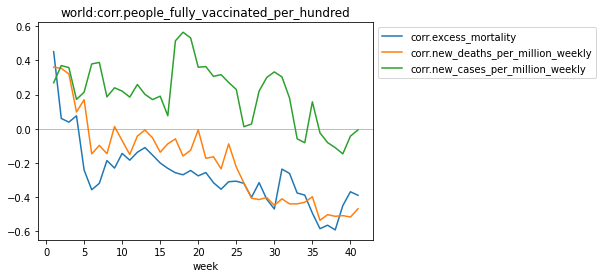

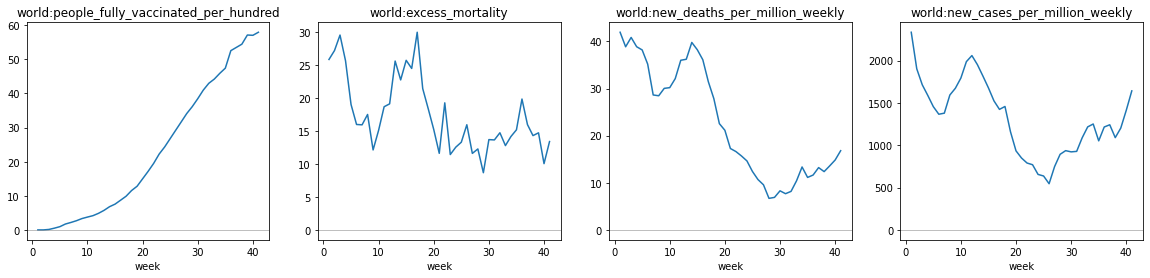

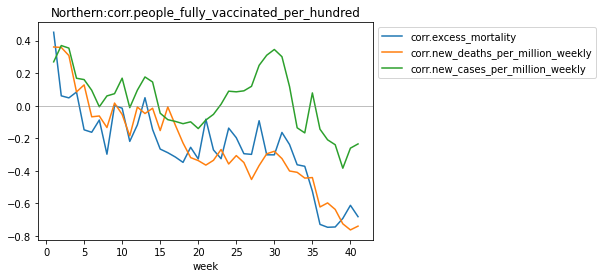

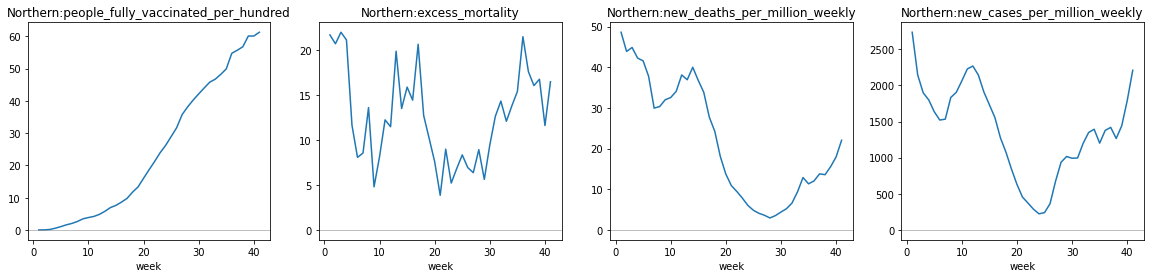

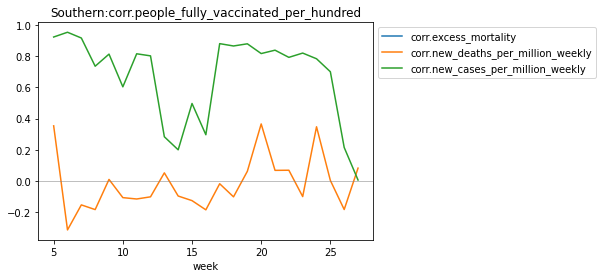

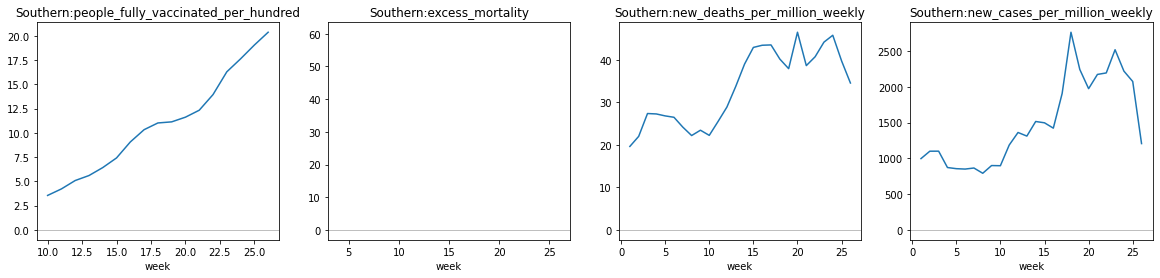

In [41]:
#plot basic data per hemisphere
hemispheres = ['world', 'Northern', 'Southern']
for con in hemispheres:
    print('{}'.format(con))
    if con == 'world':
        #mask_con = ~df_weekly.hemisphere.isna()
        mask_con = df_weekly.hemisphere==df_weekly.hemisphere
    else:
        mask_con = df_weekly.hemisphere==con
    
    ###### corr
    colx='people_fully_vaccinated_per_hundred'
    colys=['excess_mortality', 'new_deaths_per_million_weekly', 'new_cases_per_million_weekly']
    df_cor = calc_corr(df_weekly[mask_con], colx, colys)
    #plot
    if len(df_cor)==0:
        print('nothing to plot')
        continue
    fig = df_cor.plot(title=con+':corr.'+colx)
    fig.axhline(0, color='grey', linewidth=0.5)
    fig.legend(bbox_to_anchor=(1.0, 1.0)) 

    ###### basic
    colys=['people_fully_vaccinated_per_hundred', 'excess_mortality', 'new_deaths_per_million_weekly', 'new_cases_per_million_weekly']
    df_cor = df_weekly[colys][mask_con].groupby('week').mean()
    #filter out weeks with too little data points (10)
    mask = df_weekly[colys][mask_con].groupby('week').count() > 10
    df_cor = df_cor[mask]
    #plot
    if len(df_cor)==0:
        print('nothing to plot')
        continue
    figs, axes = plt.subplots(1, len(colys))
    #figs.tight_layout(pad=0.5)
    fig_w = 20
    fig_h = 4
    c = -1
    for col in df_cor.columns:
        c += 1
        fig = df_cor[col].plot(title=con+':'+col, ax=axes[c], figsize=(fig_w, fig_h))
        fig.axhline(0, color='grey', linewidth=0.5) 

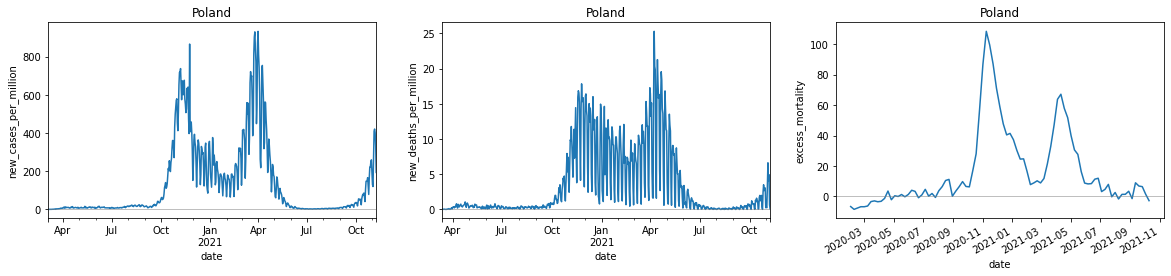

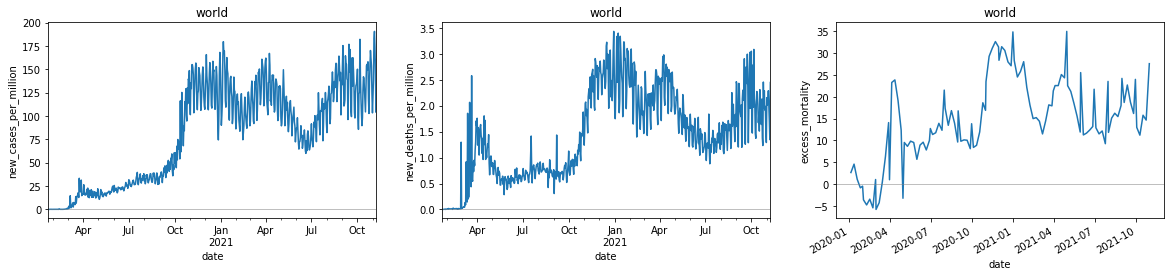

In [42]:
#plot basic data for given country
countries = ['Poland', 'world']
cols = ['new_cases_per_million', 'new_deaths_per_million', 'excess_mortality' ]
for country in countries:
    if country == 'world':
        mask_country = df.location==df.location
    else:
        mask_country = df.location==country
    figs, axes = plt.subplots(1, len(cols))
    #figs.tight_layout(pad=0.5)
    fig_w = 20
    fig_h = 4
    c = -1
    for col in cols:
        c += 1
        mask = (mask_country) & ~df[col].isna()
        title = country
        dfg = df[col][mask].groupby(df.index[mask]).mean()
        fig = dfg.plot(title=title, ax=axes[c], figsize=(fig_w, fig_h))
        fig.axhline(0, color='grey', linewidth=0.5)
        fig.set_ylabel(col)

In [ ]:
#plot weekly data for given country
countries = ['Poland', 'Norway', 'world']
cols = ['people_fully_vaccinated_per_hundred' ]
for col in cols:
    figs, axes = plt.subplots(1, len(countries))
    #figs.tight_layout(pad=0.5)
    fig_w = 20
    fig_h = 4
    c = -1
    for country in countries:
        c += 1
        if country == 'world':
            mask_country = df.location==df.location
        else:
            mask_country = df.location==country
        mask = (mask_country) & ~df[col].isna()
        title = country
        dfg = df[mask].groupby(['year','week'])[col].mean()
        fig = dfg.plot(title=title, ax=axes[c], figsize=(fig_w, fig_h))
        fig.axhline(0, color='grey', linewidth=0.5)
        fig.set_ylabel(col)


In [ ]:
#plot people_fully_vaccinated_per_hundred weekly data for given country
countries = ['Poland', 'world']
cols = ['new_cases_per_million', 'new_deaths_per_million', 'excess_mortality' ]
for country in countries:
    if country == 'world':
        mask_country = df.location==df.location
    else:
        mask_country = df.location==country
    figs, axes = plt.subplots(1, len(cols))
    #figs.tight_layout(pad=0.5)
    fig_w = 20
    fig_h = 4
    c = -1
    for col in cols:
        c += 1
        mask = (mask_country) & ~df[col].isna()
        title = country
        dfg = df[mask].groupby(['year','week'])[col].mean()
        fig = dfg.plot(title=title, ax=axes[c], figsize=(fig_w, fig_h))
        fig.axhline(0, color='grey', linewidth=0.5)
        fig.set_ylabel(col)

In [ ]:
#scatter plots per given week
cols = ['location', 'people_fully_vaccinated_per_hundred', 'new_cases_per_million_weekly', 'new_deaths_per_million_weekly', 'excess_mortality']
figs, axes = plt.subplots(1, 3)
fig_w = 20
fig_h = 4
c = -1
for coly in cols[2:]:
    c += 1
    fig = df_weekly[cols][(df_weekly.index==20) ].plot.scatter(x='people_fully_vaccinated_per_hundred', y=coly, ax=axes[c], figsize=(fig_w, fig_h), title='world.T20')
    print('%.2f' %(df_weekly[['people_fully_vaccinated_per_hundred',coly]][(df_weekly.index==20) ].corr().loc['people_fully_vaccinated_per_hundred',coly]))